
# Ergodic sampling via Langevin dynamics

In today's tutorial we will use discretizations of the overdamped Langevin equation,

$$
\dot{q} = - \nabla U(q) + \sqrt{2 \beta^{-1}} \dot{W},
$$

and the underdamped Langevin equation,

$$
\begin{aligned}
\dot{q} &= p, \\
\dot{p} &= - \nabla U(q)- \gamma p + \sqrt{2 \gamma \beta^{-1}}\dot{W},
\end{aligned}
$$

to draw samples from the associated Gibbs measure

$$
\mu(d q) = \frac{1}{Z} \exp(-\beta U(q))\, d q,
$$

where $Z = \int \exp(-\beta U(q))\, d q$

In [1]:
# For today's exercises you will need to load the following packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

from miniMD import models
from miniMD import integrators
from miniMD import outputshedulers as outp

# Exercise 1:

In ./miniMD/models.py, you can find the the class CubicDoubleWell implementing a potential function of the form of a "double well", i.e.,

$$
U(q) = (b - a/2)  (q^2-1)^2 + a/2 (q+1)
$$
where $b>0$ determines the hight of the barrier between the two wells and $a>0$ specifies the skewness of the well, i.e., the difference potential energy at $q=1$ and $q=-1$.

- Create an instance of CubicDoubleWell with parameters $a=2, b=4$. Plot the potential function, and the associated Gibbs density at unit temperature. For the computation of the Gibbs density you can use the below code snippet:

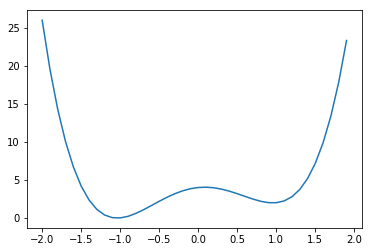

In [6]:
model = models.CubicDoubleWell(a=2.0,b=4.0)
x = np.arange(-2,2,.1)
fig,ax = plt.subplots()
ax.plot(x, model.comp_potential(x))
plt.show()

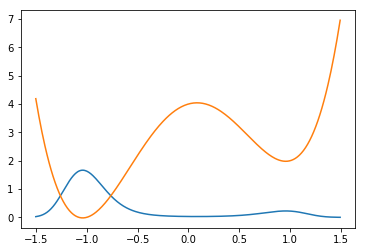

In [12]:
Tk_B = 1.0
gibbs_not_normalized = lambda q: np.exp(-Tk_B*model.comp_potential(q))
Z,err =  scipy.integrate.quad(gibbs_not_normalized,-4,4)
gibbs = lambda q: gibbs_not_normalized(q)/Z
x = np.arange(-1.5,1.5,.01)
fig,ax = plt.subplots()
ax.plot(x, gibbs(x))
ax.plot(x, model.comp_potential(x))
plt.show()

In ./miniMD/integrators.py, you can find the the class EulerMaruyamBD implementing the  Euler Maruyama scheme applied to the overdamped Langevin equation, i.e.,

$$
q_{n+1} = q_n - h \nabla U(q_n) + \sqrt{2 h \beta^{-1}} R_n, ~R_n \sim \mathcal{N}(0,1).
$$

- Create an instance of EulerMaruyamaBD with stepsize $h=0.025$ and $\beta^{-1} =1$. Use this integrator to generate a trajectory of physical time $T =  5000$. Create a plot 'time step vs q' and a (normalized) histogram accumulating all particle positions over time. Superimpose your histogram plot with a plot of the Gibbs density. For plotting the histogram you can use the below code snippet 

In [25]:
integrator = integrators.EulerMaruyamaBD(model, h=.0025, Tk_B = 1.0)
T =  5000.0;
op = outp.BufferedOutputsheduler(integrator, 
                                 Nsteps=int(T/integrator.h), 
                                 varname_list=['q'], 
                                 modprnt=1)
integrator.run(initial_values={'q' : np.array([1.0])})

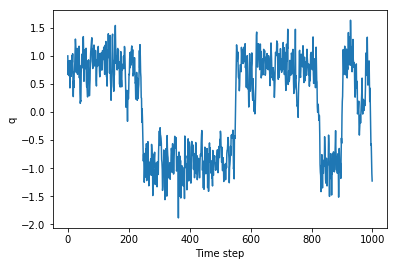

In [21]:
fig,ax = plt.subplots()
ax.plot(op.traj_q[:1000,:])
ax.set_xlabel('Time step')
ax.set_ylabel('q')
plt.show()

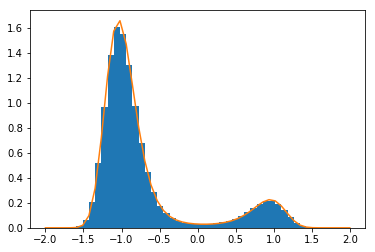

In [26]:
fig,ax = plt.subplots()
edges=np.linspace(-2,2,50,endpoint=True);
ax.hist(op.traj_q, bins=edges, normed=True, label='Histogram')
#x = np.linspace(-2,2,100)
ax.plot(edges,gibbs(edges))
plt.show()

- Reduce the stepsize $h$ in the Euler Maruyama integrator and see whether you can get a bettwe match between the histogram and the plot of the Gibbs measure

- In the file ./miniMD/integrators.py implement the Leimkuhler-Matthews method (see eq (3) in Leimkuhler, Matthews - 2013 - Rational Construction of Stochastic Numerical Methods for Molecular Sampling) as a subclass of the class BrownianDynamics. 
- Repeat the computations you did above using the Euler-Maruyama scheme with the Leimkuhler-Matthews method using the same stepsizes. What difference do you see in terms of the accuracy in the approximation of the Gibbs density?

## Exercise 2

- Implement the BAOAB, OBABO, ABOBA and OABAO splitting scheme for the underdamped Langevin euation as subclasses of the class LangevinThermostat. You might want to add an abstract class called BAOLangevinSplitting in between to save implementation work. Test your methods with  the double well potential used in exercise 1.
- Test for a simple the harmonic oscillator system whether your implementation of the BAOAB, ABOBA sample the marginal in $q$ without discretization bias.